In [ ]:
import torch
import torch.nn as nn
import os
from PIL import Image, ImageOps
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from traffic_dataset import TrafficDataset
from resnetmodel import ResNet26, ResNet38, ResNet50

In [2]:
device = torch.device("cuda")
print(device)

cuda


In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root_dir_train = "data/train"
root_dir_val = "data/validation"
root_dir_test = "data/test"

train_dataset = TrafficDataset(root_dir_train, transform=transform,  augmentation=True)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TrafficDataset(root_dir_val, transform=transform, augmentation=False)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

test_dataset = TrafficDataset(root_dir_test, transform=transform, augmentation=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [14]:
def count_images_per_class(dataset):
    class_counts = {cls_name: 0 for cls_name in dataset.classes}

    for img_path, label in zip(dataset.img_paths, dataset.labels):
        class_name = dataset.classes[label]
        class_counts[class_name] += 1

    return class_counts

train_class_counts = count_images_per_class(train_dataset)
test_class_counts = count_images_per_class(test_dataset)
validation_class_counts = count_images_per_class(val_dataset)

data = []
for class_name in train_dataset.classes:
    train_count = train_class_counts[class_name]
    test_count = test_class_counts[class_name]
    validation_count = validation_class_counts[class_name]
    data.append((class_name, train_count, test_count, validation_count))


max_class_length = max(len(class_name) for class_name, _, _, _ in data)
max_count_length = max(len(str(count)) for _, count, _, _ in data)


print("Images per class:")
print(f"+{'-' * (max_class_length + 2)}+{'-' * (max_count_length + 2)}+{'-' * (max_count_length + 2)}+{'-' * (max_count_length + 2)}+")
print(f"| {'Class':<{max_class_length}} | {'Train':^{max_count_length}}| {'Test':^{max_count_length}} | {'Val':^{max_count_length}} |")
print(f"+{'-' * (max_class_length + 2)}+{'-' * (max_count_length + 2)}+{'-' * (max_count_length + 2)}+{'-' * (max_count_length + 2)}+")
for class_name, train_count, test_count, validation_count in data:
    print(f"| {class_name:<{max_class_length}} | {train_count:^{max_count_length}} | {test_count:^{max_count_length}} | {validation_count:^{max_count_length}} |")
print(f"+{'-' * (max_class_length + 2)}+{'-' * (max_count_length + 2)}+{'-' * (max_count_length + 2)}+{'-' * (max_count_length + 2)}+")

Images per class:
+-------------+------+------+------+
| Class       | Train| Test | Val  |
+-------------+------+------+------+
| empty       | 5525 |  64  | 120  |
| high        | 2655 |  64  |  94  |
| low         | 3440 |  64  |  70  |
| medium      | 1880 |  63  |  37  |
| traffic-jam | 905  |  21  |  16  |
+-------------+------+------+------+


In [4]:
criterion = nn.CrossEntropyLoss()

In [5]:
import time
import psutil

def train_model(model, train_dataloader, val_dataloader, test_dataloader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_dataloader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_dataloader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print("Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Accuracy: {:.2f}%".format(epoch+1, num_epochs, train_loss, val_loss, accuracy))

    end_time = time.time()
    training_time = end_time - start_time

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    model.eval()
    num_samples = 100 
    inference_start_time = time.time()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            if i == num_samples:
                break
    inference_end_time = time.time()
    inference_time = (inference_end_time - inference_start_time) / num_samples

    process = psutil.Process()
    memory_footprint = process.memory_info().rss / 1024 ** 2

    print("Training Time: {:.2f} seconds".format(training_time))
    print("Inference Speed: {:.2f} seconds per sample".format(inference_time))
    print("Memory Footprint: {:.2f} MB".format(memory_footprint))

Epoch [1/10], Train Loss: 0.9517, Val Loss: 0.8494, Accuracy: 49.64%
Epoch [2/10], Train Loss: 0.5479, Val Loss: 0.6214, Accuracy: 73.91%
Epoch [3/10], Train Loss: 0.3342, Val Loss: 1.9042, Accuracy: 53.26%
Epoch [4/10], Train Loss: 0.1551, Val Loss: 0.6867, Accuracy: 82.25%
Epoch [5/10], Train Loss: 0.0733, Val Loss: 0.4781, Accuracy: 80.43%
Epoch [6/10], Train Loss: 0.0388, Val Loss: 1.5834, Accuracy: 63.04%
Epoch [7/10], Train Loss: 0.0348, Val Loss: 0.6850, Accuracy: 76.45%
Epoch [8/10], Train Loss: 0.0247, Val Loss: 0.5850, Accuracy: 80.80%
Epoch [9/10], Train Loss: 0.0174, Val Loss: 0.5687, Accuracy: 82.61%
Epoch [10/10], Train Loss: 0.0188, Val Loss: 0.6950, Accuracy: 75.00%


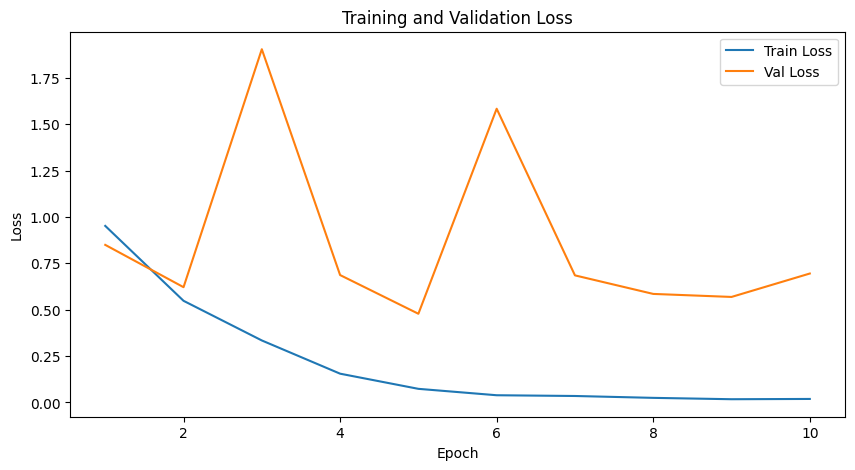

Training Time: 144.69 seconds
Inference Speed: 0.01 seconds per sample
Memory Footprint: 1145.97 MB


In [24]:
model = ResNet26(num_classes=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_model(model, train_dataloader, val_dataloader, test_dataloader, criterion, optimizer)

In [ ]:
model = ResNet38(num_classes=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_model(model, train_dataloader, val_dataloader, test_dataloader, criterion, optimizer, num_epochs=30)

Epoch [1/30], Train Loss: 0.4243, Val Loss: 0.6006, Accuracy: 72.83%
Epoch [2/30], Train Loss: 0.1150, Val Loss: 0.5738, Accuracy: 82.25%
Epoch [3/30], Train Loss: 0.0705, Val Loss: 0.5795, Accuracy: 80.43%
Epoch [4/30], Train Loss: 0.0555, Val Loss: 0.7225, Accuracy: 80.07%
Epoch [5/30], Train Loss: 0.0444, Val Loss: 0.6908, Accuracy: 80.07%
Epoch [6/30], Train Loss: 0.0425, Val Loss: 0.7048, Accuracy: 77.17%
Epoch [7/30], Train Loss: 0.0166, Val Loss: 0.6731, Accuracy: 78.99%
Epoch [8/30], Train Loss: 0.0505, Val Loss: 0.8356, Accuracy: 74.64%
Epoch [9/30], Train Loss: 0.0319, Val Loss: 0.6270, Accuracy: 77.17%
Epoch [10/30], Train Loss: 0.0213, Val Loss: 0.6004, Accuracy: 81.52%
Epoch [11/30], Train Loss: 0.0376, Val Loss: 0.5860, Accuracy: 81.88%
Epoch [12/30], Train Loss: 0.0211, Val Loss: 0.8031, Accuracy: 80.07%
Epoch [13/30], Train Loss: 0.0242, Val Loss: 0.6116, Accuracy: 78.62%
Epoch [14/30], Train Loss: 0.0073, Val Loss: 0.6327, Accuracy: 79.71%
Epoch [15/30], Train Loss: 0.

Epoch [1/10], Train Loss: 0.9979, Val Loss: 1.6920, Accuracy: 27.17%
Epoch [2/10], Train Loss: 0.5275, Val Loss: 0.7070, Accuracy: 64.13%
Epoch [3/10], Train Loss: 0.2742, Val Loss: 0.8627, Accuracy: 64.49%
Epoch [4/10], Train Loss: 0.2523, Val Loss: 0.6488, Accuracy: 77.17%
Epoch [5/10], Train Loss: 0.1180, Val Loss: 0.7244, Accuracy: 75.00%
Epoch [6/10], Train Loss: 0.0806, Val Loss: 0.8217, Accuracy: 77.17%
Epoch [7/10], Train Loss: 0.0373, Val Loss: 0.8772, Accuracy: 71.74%
Epoch [8/10], Train Loss: 0.0585, Val Loss: 0.8126, Accuracy: 68.84%
Epoch [9/10], Train Loss: 0.0582, Val Loss: 0.9077, Accuracy: 69.57%
Epoch [10/10], Train Loss: 0.0383, Val Loss: 0.7182, Accuracy: 76.81%


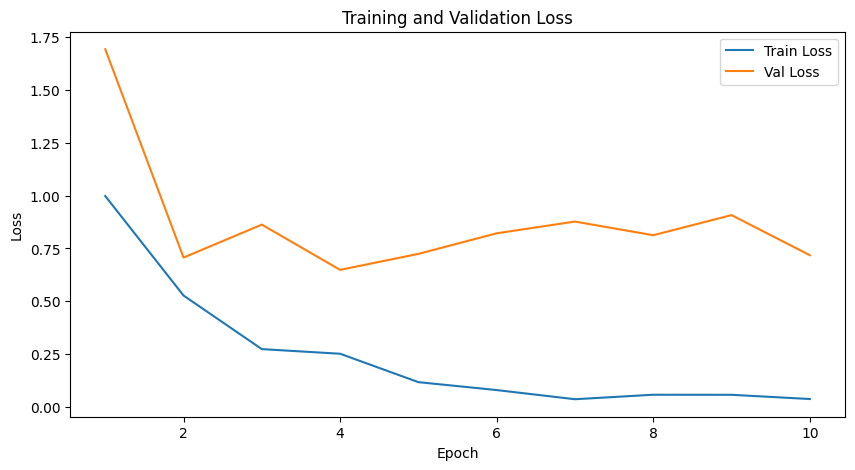

Training Time: 171.29 seconds
Inference Speed: 0.01 seconds per sample
Memory Footprint: 1167.91 MB


In [30]:
model = ResNet50(num_classes=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_model(model, train_dataloader, val_dataloader, test_dataloader, criterion, optimizer)